# 08-03: Robustness against Random Node Failures

*December 7th 2022*  

In the final practice session, we study the robustness of networks against random node failures.

In [1]:
import pathpy as pp
import numpy as np

from collections import Counter

from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")

# Robustness of random networks

Apart from the question at which point a giant connected component emerges as we gradually *add* links in a random network, the question at which point the giant connected component is destroyed as we gradually *remove* nodes and associated edges is a major concern in the study of robustness in complex networks. In the lecture, we analytically studied this based on generating functions, and here we explore it experimentally. 

We first write a function that removes a each node in the network with probability $q$.

In [7]:
def remove_random_nodes(network, q):
    n = network.copy()
    for v in n.nodes.uids:
        if np.random.random()<q:
            n.remove_node(v)
    return n

We visualize a random network with random failed nodes, as well as the resulting connected component. We use pathpy's styling features to highlight failed nodes. This visualization matches the visualizations accompanying the generating function analysis in Lecture L08.

In [8]:
n = pp.generators.ER_np(n=200, p=3/200).largest_connected_component()

n_after = remove_random_nodes(n, 0.33)
lcc = n_after.largest_connected_component()

layout = pp.layout(n, layout='fr')

for v in n.nodes.uids:
    if v not in n_after.nodes.uids:
        n.nodes[v]['color'] = 'Red'
        n.nodes[v]['style'] = '{draw opacity=0, fill opacity=0.25}'   
    else:
        n.nodes[v]['color'] = 'CornflowerBlue'
        n.nodes[v]['style'] = '{draw opacity=1, fill opacity=1}'

n.plot(node_label='', node_id_as_label=False, layout=layout, node_size=10, edge_color='lightgray')
n.plot('network_failed_nodes.pdf', node_label='', node_id_as_label=False, layout=layout, node_size=10, edge_color='lightgray')

We create a second plot where the links incident to red nodes are removed and the largest surviving connected component is coloured in green.

In [9]:
for v in lcc.nodes.uids:
    n.nodes[v]['color'] = 'ForestGreen'
    n.nodes[v]['style'] = '{draw opacity=1, fill opacity=1}'

for e in n.edges:    
    if e.v.uid in lcc.nodes.uids and e.w.uid in lcc.nodes.uids:
        n.edges[e.uid]['color'] = 'black'
        n.edges[e.uid]['opacity'] = 1.0
    elif e.v.uid in n_after.nodes.uids and e.w.uid in n_after.nodes.uids:
        n.edges[e.uid]['color'] = 'gray'
        n.edges[e.uid]['opacity'] = 0.5
    else:
        n.edges[e.uid]['color'] = 'white'
        n.edges[e.uid]['opacity'] = 0.0

n.plot(node_label='', node_id_as_label=False, layout=layout, node_size=10)
n.plot(filename='network_surviving_lcc.pdf', node_label='', node_id_as_label=False, layout=layout, node_size=10)

For the sake of convenience, we write a function that repeatedly performs the node removal experiment in random microstates for different removal probabilities. The function then plots the fraction of nodes in the largest connected component in the surviving network.

In [3]:
def plot_ER_node_removal(n, p, q_range, samples=5, node_removal=remove_random_nodes):
    sgcc = []

    for q in tqdm(q_range, 'Running simulations'):
        s = 0
        for i in range(samples):
            g = pp.generators.random_graphs.ER_np(n=n, p = p, directed=False, loops = False)
            g = node_removal(g, q)
            if g.number_of_nodes()==0:
                s += 0
            else:
                s += g.largest_component_size()/g.number_of_nodes()
        sgcc.append(s/samples)
    plt.clf()
    plt.grid(True)
    plt.plot(q_range, sgcc, color="red")
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.xlabel('$q$', fontsize=30)
    plt.ylabel('size of surviving lcc', fontsize=20)
    plt.ylim((0,1))
    plt.xlim((min(q_range),max(q_range)))
    plt.subplots_adjust(bottom=0.2)
    plt.subplots_adjust(left=0.15)
    plt.show()

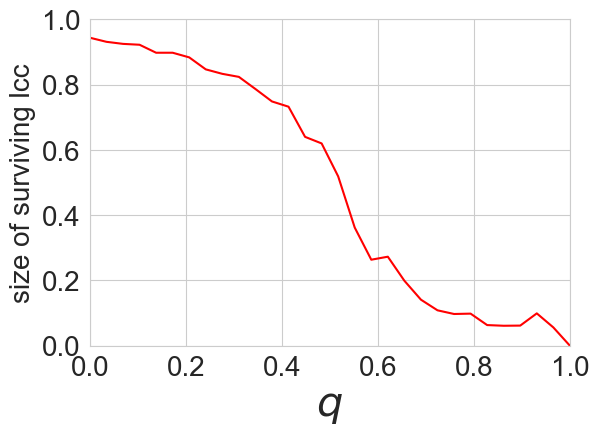

In [4]:
plot_ER_node_removal(500, 0.006, np.linspace(0, 1, 30), samples=10)

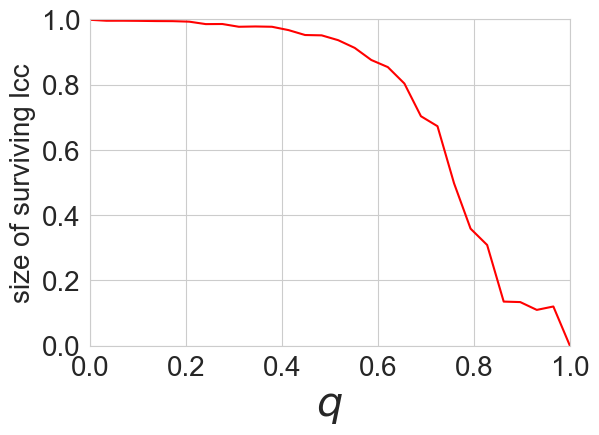

In [5]:
plot_ER_node_removal(500, 0.012, np.linspace(0, 1, 30), samples=10)